<a href="https://colab.research.google.com/github/hunkim98/earth_science/blob/main/lecture/EPS210_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Harvard EPS-210 AI for Earth and Planetary Science

Instructor: Mostafa Mouasvi

# Lab 2: Traditional Machine Learning - Supervised Methods

*  **Activity 1:** Random Forest for Lithology Classification from Well Logs (9 Parts, 55 Minutes)
*  **Activity 2:** Using Automatic Feature Engineering (AFE) Tools (4 Parts, 15 Minutes)


---
## **Activity 1:** Random Forest for Lithology Classification from Well Logs (9 Parts, 55 Minutes)

### Background
**Lithology Classification**: Classifying lithology (the physical characteristics of rock) involves identifying whether the rock is sandstone, shale, limestone, dolomite, or coal.

**Well Logs**: A well log (also known as a borehole log) is a continuous record of the physical, chemical, and structural properties of rock formations as a function of depth. These measurements are typically collected by lowering sensors (tools) into a wellbore on a wireline or while drilling. In the oil and gas and geothermal industries, well logs act as the "eyes" of the geoscientist, providing a high-resolution map of the subsurface that would otherwise be invisible.

**Why is this important?**
Accurate lithology classification is the first step in:

  * Calculating Porosity (how much space is in the rock)

  * Mapping Reservoirs (understanding the ratio of good reservoir rock to non-productive shale)

  * Geomechanical Modeling (determining where it is safe to drill or perform hydraulic fracturing)

### Learning Objectives

By the end of this lab, you will be able to:

1. Understand how Random Forest works and why it's effective for geological classification
2. Preprocess real-world geophysical well log data for machine learning
3. Build, tune, and validate Random Forest models systematically
4. Interpret model results in a geological context
5. Apply best practices for hyperparameter optimization

---

### The Problem: Lithology Prediction from Well Logs

**Why this matters:** Lithology identification is fundamental to petroleum exploration, groundwater studies, and geological mapping. Traditionally, lithology is determined through expensive core sampling or time-consuming manual log interpretation. Machine learning offers an automated, consistent approach to predict lithology from continuous well log measurements.

**The Data:** We use the [FORCE 2020 Competition Dataset](https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition) from the Norwegian Continental Shelf. This is real-world data from 98 training wells with:

- **Well logs**: CALI, RDEP, RHOB, GR, NPHI, PEF, DTC, DTS, and more
- **Spatial information**: X_LOC, Y_LOC, Z_LOC, DEPTH_MD
- **Stratigraphic context**: GROUP, FORMATION names
- **12 lithology classes** with significant class imbalance

**Note:** We use a **10% random sample** of wells to reduce computation time.

**Challenge:** Real data has ~50-80% missing values in many logs, class imbalance (shales dominate), and measurement noise. This is far more challenging than synthetic datasets!

**Reference:** Bormann P., Aursand P., Dilib F., Dischington P., Manral S. 2020. FORCE Machine Learning Competition.

---

## Part 1: Setup and Data Understanding

In [2]:
# Import libraries
import time
import os
import urllib.request
import zipfile
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, learning_curve
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

SEED = 42
np.random.seed(SEED)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

print("Setup complete!")

Setup complete!


In [3]:
# Download FORCE 2020 data
URL = 'https://raw.githubusercontent.com/bolgebrygg/Force-2020-Machine-Learning-competition/master/lithology_competition/data/train.zip'

if not os.path.exists('train.csv'):
    print("Downloading data...")
    urllib.request.urlretrieve(URL, 'train.zip')
    with zipfile.ZipFile('train.zip', 'r') as z:
        z.extractall('.')
    os.remove('train.zip')
    print("Download complete!")
else:
    print("Data already exists.")

Download complete!


In [4]:
# Load full dataset (semicolon separator)
df_full = pd.read_csv('train.csv', sep=';')
print(f"{'='*60}")
print(f"Dataset shape: {df_full.shape}")
print(f"Number of wells: {df_full['WELL'].nunique()}")
print(f"Number of samples: {len(df_full):,}")

Dataset shape: (1170511, 29)
Number of wells: 98
Number of samples: 1,170,511


In [5]:
df_full.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
30423,15/9-15,2343.304000,436806.46875,6463010.5,-2318.007324,ROGALAND GP.,Lista Fm.,14.882113,0.771240,0.771240,...,12.761565,NaN,2.632109,0.115312,0.143792,NaN,NaN,0.570850,65000,1.0
1073159,35/3-7 S,3582.467851,543919.75000,6856653.5,-3477.858154,CROMER KNOLL GP.,Roedby Fm.,8.645628,NaN,5.599961,...,10.556081,150.206314,NaN,-0.007215,NaN,6.627153,10.410796,NaN,65000,1.0
436368,25/9-1,734.814000,483545.34375,6590313.0,-709.762207,NORDLAND GP.,Utsira Fm.,NaN,NaN,NaN,...,109.271744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65030,1.0
290688,25/3-1,1075.968000,487291.25000,6643945.0,-1053.937988,HORDALAND GP.,NaN,17.646826,NaN,0.867609,...,7.970956,NaN,0.215513,0.051340,0.958611,NaN,NaN,NaN,30000,1.0
1118085,35/9-10 S,3580.061600,537897.75000,6791142.5,-3069.179688,BAAT GP.,Rannoch Fm.,8.572706,NaN,7.634528,...,31.773550,140.671463,NaN,0.039784,NaN,NaN,NaN,NaN,65000,1.0
564809,31/2-7,543.912932,524586.50000,6747128.5,-518.902283,NORDLAND GP.,NaN,17.800201,NaN,2.290902,...,NaN,NaN,NaN,0.005903,NaN,NaN,NaN,NaN,65000,1.0
745628,33/9-17,2600.577985,438440.25000,6814142.5,-2573.349854,SHETLAND GP.,Kyrre Fm.,8.527467,1.440498,1.394500,...,NaN,NaN,NaN,-0.004298,NaN,NaN,6.810722,2.037278,65000,1.0
531364,30/6-5,2325.034400,497435.71875,6728314.0,-2299.976318,SHETLAND GP.,Lista Fm.,14.654340,1.958396,1.847564,...,NaN,NaN,NaN,0.000692,NaN,NaN,NaN,2.087825,70000,1.0
936673,34/8-1,2787.793023,469565.43750,6803862.0,-2746.412354,BAAT GP.,Tarbert Fm.,8.000000,1.489495,54.155262,...,NaN,NaN,NaN,-0.066900,NaN,NaN,NaN,1.821454,30000,1.0
144292,16/4-1,1058.201604,449949.31250,6500257.0,-1033.074951,HORDALAND GP.,Utsira Fm.,16.719784,1.197158,1.202889,...,1.831535,NaN,1.969784,-0.004111,0.140197,NaN,NaN,NaN,65000,1.0


## Inspecting available logs and interpretations

The data contains the metadata columns

* WELL: well name
* DEPTH_MD: measured depth
* X_LOC: UTM X coordinate
* Y_LOC: UTM Y coordinate
* Z_LOC: DEPTH
* GROUP: NPD lithostratigraphy group
* FORMATION: NPD lithostratgraphy formation

The data contains the well log curves. For example the following:

* BS: Bit Size
* CALI: Caliper
* RDEP: Deep Resistivity
* RHOB: Bulk Density
* GR: Raw gamma data
* SGR: Spectral Gamma Ray
* RMED: Medium Resistivity
* ROP: Rate of Penetration
* NPHI: Neutron Porosity
* PEF: Photoelectric Absorption Factor
* RSHA: Shallow Resistivity
* DTS: Sonic (Sheer Slowness)
* DTC: Sonic (Compressional Slowness)

* FORCE_2020_LITHOFACIES_LITHOLOGY: lithology class label
* FORCE_2020_LITHOFACIES_CONFIDENCE: confidence in lithology interpretation (1: high, 2: medium, 3: low)

In [6]:
wells = df_full['WELL'].unique()
wells

<StringArray>
[    '15/9-13',     '15/9-15',     '15/9-17',      '16/1-2',    '16/1-6 A',
     '16/10-1',     '16/10-2',     '16/10-3',     '16/10-5', '16/11-1 ST3',
   '16/2-11 A',     '16/2-16',      '16/2-6',      '16/4-1',      '16/5-3',
      '16/7-4',      '16/7-5',      '16/8-1',     '17/11-1',    '25/11-15',
  '25/11-19 S',     '25/11-5',  '25/2-13 T4',     '25/2-14',      '25/2-7',
      '25/3-1',      '25/4-5',      '25/5-1',      '25/5-4',      '25/6-1',
      '25/6-2',      '25/6-3',      '25/7-2',    '25/8-5 S',      '25/8-7',
      '25/9-1',      '26/4-1',      '29/6-1',      '30/3-3',    '30/3-5 S',
      '30/6-5',      '31/2-1',   '31/2-19 S',      '31/2-7',      '31/2-8',
      '31/2-9',      '31/3-1',      '31/3-2',      '31/3-3',      '31/3-4',
     '31/4-10',      '31/4-5',    '31/5-4 S',      '31/6-5',      '31/6-8',
      '32/2-1',      '33/5-2',    '33/6-3 S',      '33/9-1',     '33/9-17',
    '34/10-19',    '34/10-21',    '34/10-33',    '34/10-35',     '34/11-1'

In [7]:
# Sample percentage of wells for this lab (adjust as needed)
SAMPLE_FRAC = 0.10  # 10% of wells

all_wells = df_full['WELL'].unique()
n_wells = int(len(all_wells) * SAMPLE_FRAC)
sampled_wells = np.random.choice(all_wells, size=n_wells, replace=False)

df = df_full[df_full['WELL'].isin(sampled_wells)].copy()

print(f"Sampled: {len(sampled_wells)} wells ({SAMPLE_FRAC*100:.0f}%)")
print(f"Samples: {len(df):,}")

Sampled: 9 wells (10%)
Samples: 134,256


In [8]:
# Lithology key (from FORCE 2020 starter notebook)
lithology_keys = {
    30000: 'Sandstone',
    65030: 'Sandstone/Shale',
    65000: 'Shale',
    80000: 'Marl',
    74000: 'Dolomite',
    70000: 'Limestone',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Anhydrite',
    99000: 'Tuff',
    90000: 'Coal',
    93000: 'Basement'
}

# Map codes to names
df['LITHOLOGY'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

print("Lithology Distribution:")
print("="*50)
lithology_counts = df['LITHOLOGY'].value_counts()
for lith, count in lithology_counts.items():
    pct = count / len(df) * 100
    print(f"  {lith:20s}: {count:7,} samples ({pct:5.1f}%)")
print(f"\n  {'TOTAL':20s}: {len(df):7,} samples")

Lithology Distribution:
  Shale               :  65,436 samples ( 48.7%)
  Sandstone/Shale     :  41,423 samples ( 30.9%)
  Sandstone           :  19,190 samples ( 14.3%)
  Limestone           :   4,549 samples (  3.4%)
  Tuff                :   2,227 samples (  1.7%)
  Marl                :   1,151 samples (  0.9%)
  Coal                :     187 samples (  0.1%)
  Dolomite            :      88 samples (  0.1%)
  Anhydrite           :       5 samples (  0.0%)

  TOTAL               : 134,256 samples


---

## Part 2: Exploratory Data Analysis

In [9]:
# Basic statistics for key well logs
log_columns = ['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'DTS',  'BS', 'DRHO']
available_logs = [col for col in log_columns if col in df.columns]

print("Summary Statistics for Well Logs:")
print("="*60)
df[available_logs].describe().round(2)

Summary Statistics for Well Logs:


,CALI,RDEP,RHOB,GR,NPHI,PEF,DTC,DTS,BS,DRHO
count,134078.00,134240.00,116902.00,134256.00,75155.00,92672.00,126390.00,46328.00,61067.00,110295.00
mean,13.65,2.95,2.32,64.56,0.38,7.76,115.72,212.79,11.47,0.00
std,4.18,20.90,0.25,28.71,0.17,10.96,26.22,78.83,3.65,0.07
min,3.02,0.14,1.18,0.62,0.02,0.12,50.65,85.37,6.50,-6.04
25%,9.26,1.02,2.13,42.72,0.26,3.73,93.23,156.09,8.50,-0.01
50%,12.91,1.57,2.36,60.05,0.36,4.93,112.80,190.68,8.50,-0.00
75%,17.62,2.57,2.53,84.86,0.46,7.45,139.39,248.36,12.25,0.02
max,25.72,1538.89,3.46,265.66,1.00,318.37,188.65,676.58,26.00,0.94


## Missing logs

Notice that some of the curves are NaN. This is an imporant aspect of this dataset and of this competition. The only log columns that are guaranteed to be present are WELL, DEPT, GROUP, and GR. All other logs can (and will) be missing from some parts of the dataset.

In [10]:
df.isna().any()

WELL                                 False
DEPTH_MD                             False
X_LOC                                 True
Y_LOC                                 True
Z_LOC                                 True
GROUP                                 True
FORMATION                             True
CALI                                  True
RSHA                                  True
RMED                                  True
RDEP                                  True
RHOB                                  True
GR                                   False
SGR                                   True
NPHI                                  True
PEF                                   True
DTC                                   True
SP                                    True
BS                                    True
ROP                                   True
DTS                                   True
DCAL                                  True
DRHO                                  True
MUDWEIGHT  

In [11]:
# Missing value analysis
print("Missing Value Analysis:")
print("="*60)

missing_stats = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(1),
    'Available %': (100 - df.isnull().sum() / len(df) * 100).round(1)
}).sort_values('Missing %', ascending=False)

print("\nColumns with missing data (sorted by % missing):")
print(missing_stats[missing_stats['Missing %'] > 0].head(20))

Missing Value Analysis:

Columns with missing data (sorted by % missing):
           Missing Count  Missing %  Available %
ROPA              124906       93.0          7.0
SGR               123370       91.9          8.1
DCAL              119767       89.2         10.8
RMIC              118721       88.4         11.6
MUDWEIGHT         111753       83.2         16.8
RXO                97372       72.5         27.5
DTS                87928       65.5         34.5
ROP                75583       56.3         43.7
BS                 73189       54.5         45.5
RSHA               66043       49.2         50.8
NPHI               59101       44.0         56.0
SP                 51571       38.4         61.6
PEF                41584       31.0         69.0
DRHO               23961       17.8         82.2
FORMATION          17783       13.2         86.8
RHOB               17354       12.9         87.1
DTC                 7866        5.9         94.1
CALI                 178        0.1         

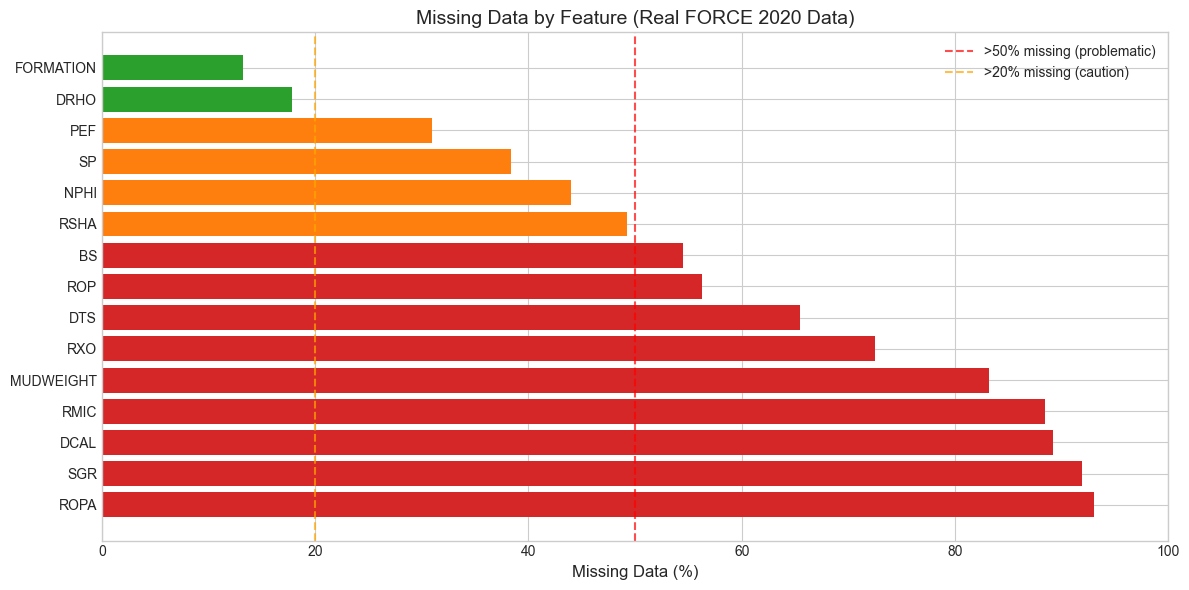


KEY INSIGHT: Many logs have >50% missing values - this is REAL data!
We need to carefully select features with sufficient coverage.


In [12]:
# Visualize missing data pattern
fig, ax = plt.subplots(figsize=(12, 6))

# Select columns with some missing data for visualization
cols_with_missing = missing_stats[missing_stats['Missing %'] > 0].index[:15]
missing_pct = missing_stats.loc[cols_with_missing, 'Missing %']

colors = ['#d62728' if x > 50 else '#ff7f0e' if x > 20 else '#2ca02c' for x in missing_pct]
bars = ax.barh(range(len(missing_pct)), missing_pct.values, color=colors)
ax.set_yticks(range(len(missing_pct)))
ax.set_yticklabels(missing_pct.index)
ax.set_xlabel('Missing Data (%)', fontsize=12)
ax.set_title('Missing Data by Feature (Real FORCE 2020 Data)', fontsize=14)
ax.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='>50% missing (problematic)')
ax.axvline(x=20, color='orange', linestyle='--', alpha=0.7, label='>20% missing (caution)')
ax.legend(loc='upper right')
ax.set_xlim(0, 100)
plt.tight_layout()
plt.show()

print("\nKEY INSIGHT: Many logs have >50% missing values - this is REAL data!")
print("We need to carefully select features with sufficient coverage.")

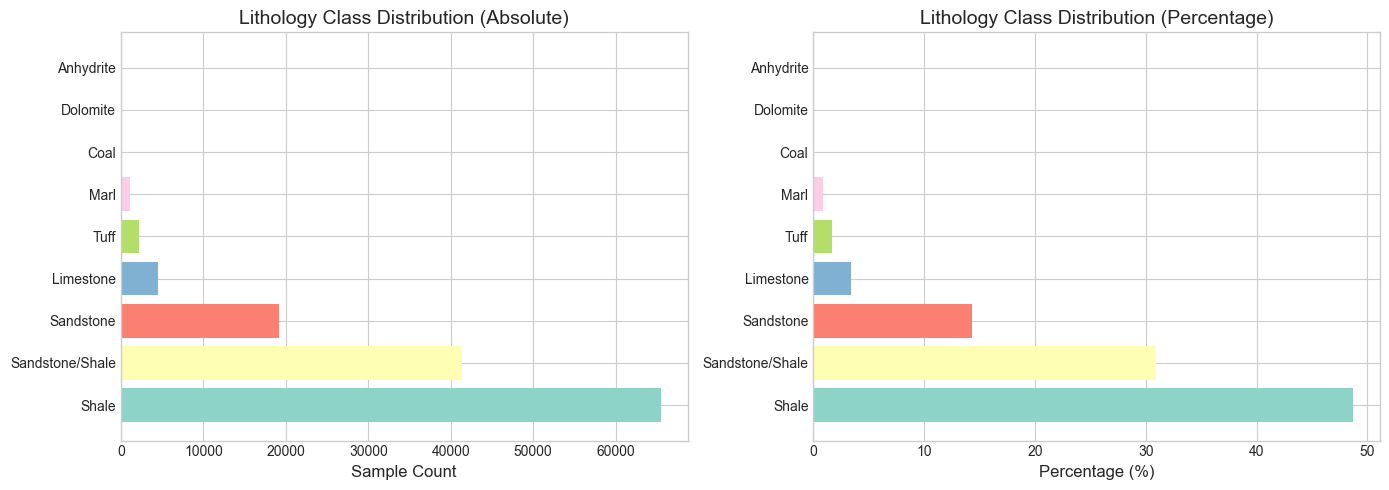


CLASS IMBALANCE:
   Most common: Shale (48.7%)
   Least common: Anhydrite (0.0%)
   Imbalance ratio: 13087:1


In [13]:
# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute counts
class_counts = df['LITHOLOGY'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
axes[0].barh(class_counts.index, class_counts.values, color=colors)
axes[0].set_xlabel('Sample Count', fontsize=12)
axes[0].set_title('Lithology Class Distribution (Absolute)', fontsize=14)
axes[0].ticklabel_format(style='plain', axis='x')

# Percentage
class_pct = (class_counts / len(df) * 100).round(1)
axes[1].barh(class_pct.index, class_pct.values, color=colors)
axes[1].set_xlabel('Percentage (%)', fontsize=12)
axes[1].set_title('Lithology Class Distribution (Percentage)', fontsize=14)

plt.tight_layout()
plt.show()

print(f"\nCLASS IMBALANCE:")
print(f"   Most common: {class_counts.index[0]} ({class_pct.iloc[0]:.1f}%)")
print(f"   Least common: {class_counts.index[-1]} ({class_pct.iloc[-1]:.1f}%)")
print(f"   Imbalance ratio: {class_counts.max() / class_counts.min():.0f}:1")

Look at some log curves for a couple of wells

Text(0, 0.5, 'DEPTH_MD')

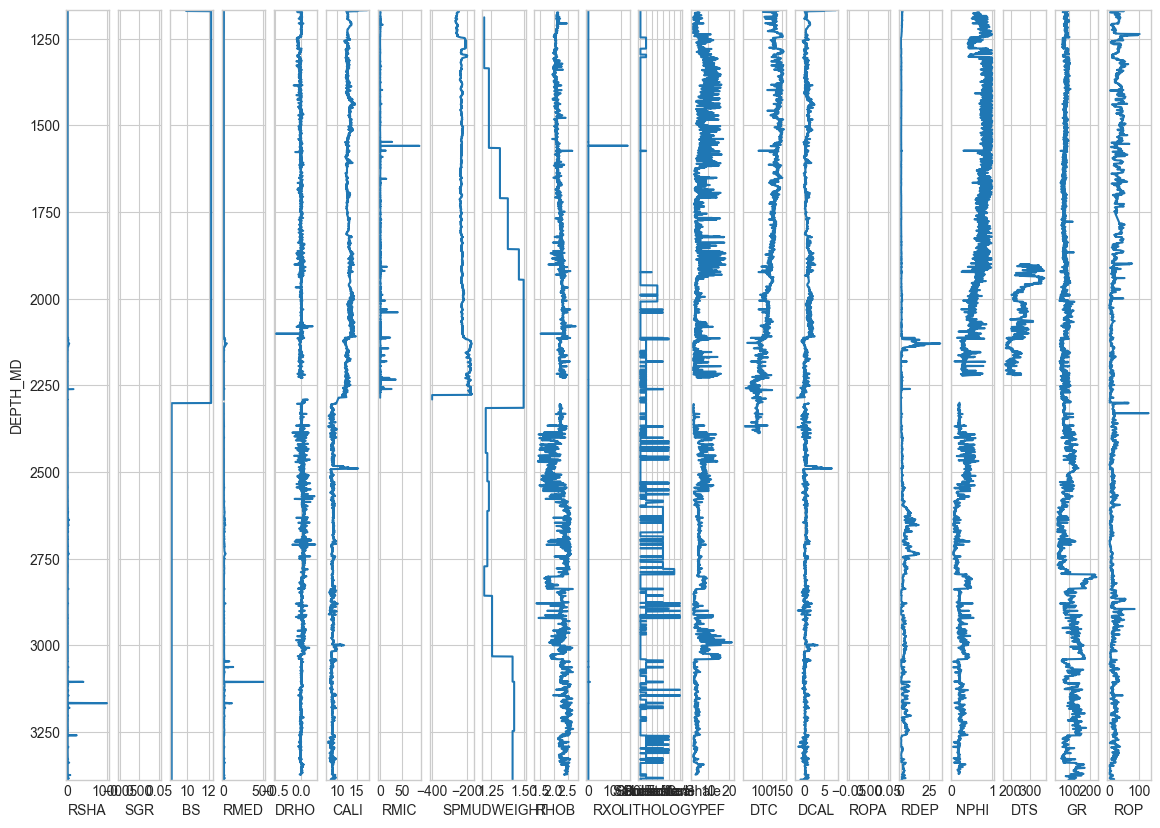

In [14]:
well_data = df[df['WELL'] == sampled_wells[0]] # Use a well from the sampled_wells
fig, axs = plt.subplots(1, len(well_data.columns)-9, figsize=(14, 10), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
                                                     'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
                                                    'X_LOC', 'Y_LOC', 'Z_LOC'])):
    axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
    axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])
axs[0].set_ylabel('DEPTH_MD')

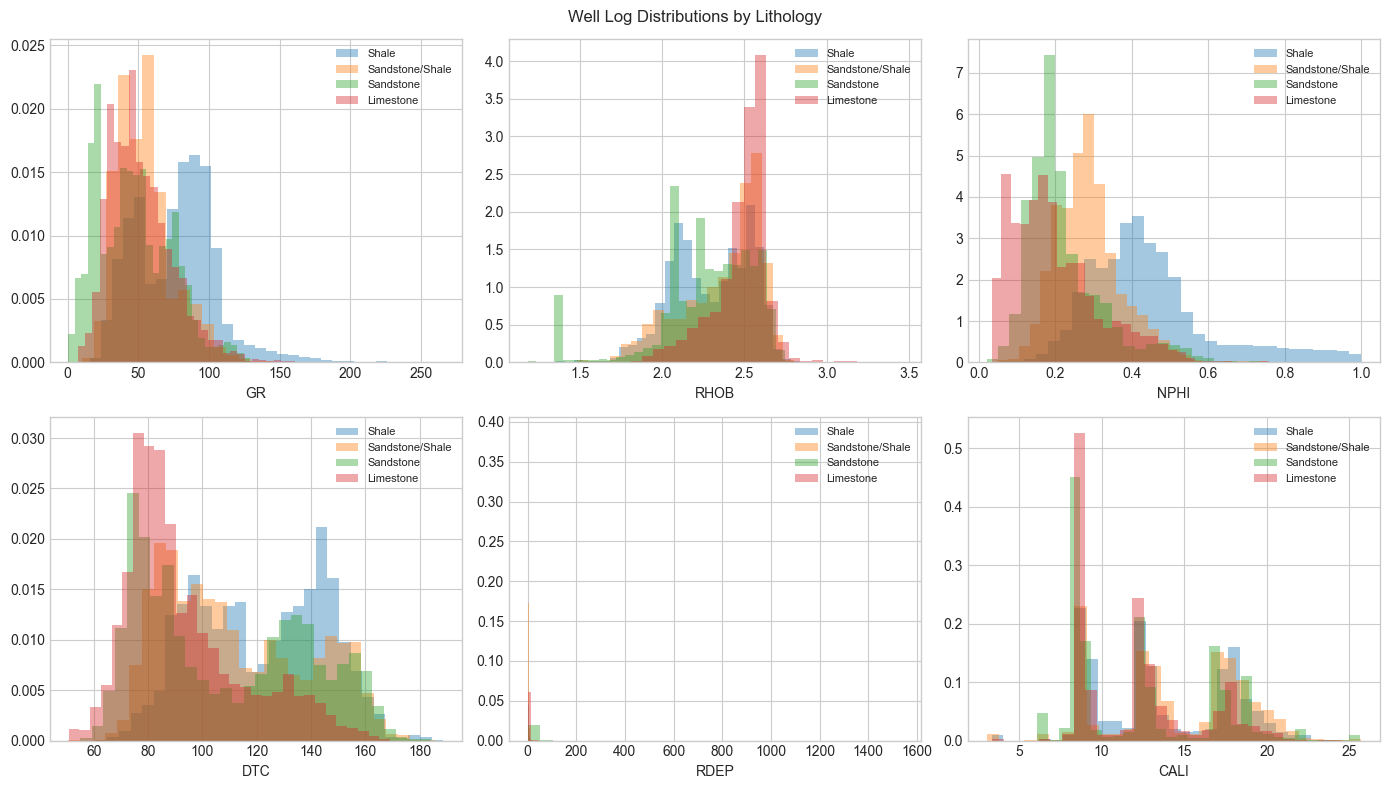

In [15]:
# Log distributions by lithology
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
logs = ['GR', 'RHOB', 'NPHI', 'DTC', 'RDEP', 'CALI']
top_liths = df['LITHOLOGY'].value_counts().head(4).index

for ax, log in zip(axes.flat, logs):
    if log in df.columns:
        for lith in top_liths:
            data = df[df['LITHOLOGY'] == lith][log].dropna()
            if len(data) > 50:
                ax.hist(data, alpha=0.4, bins=30, density=True, label=lith)
        ax.set_xlabel(log)
        ax.legend(fontsize=8)
plt.suptitle('Well Log Distributions by Lithology')
plt.tight_layout()
plt.show()

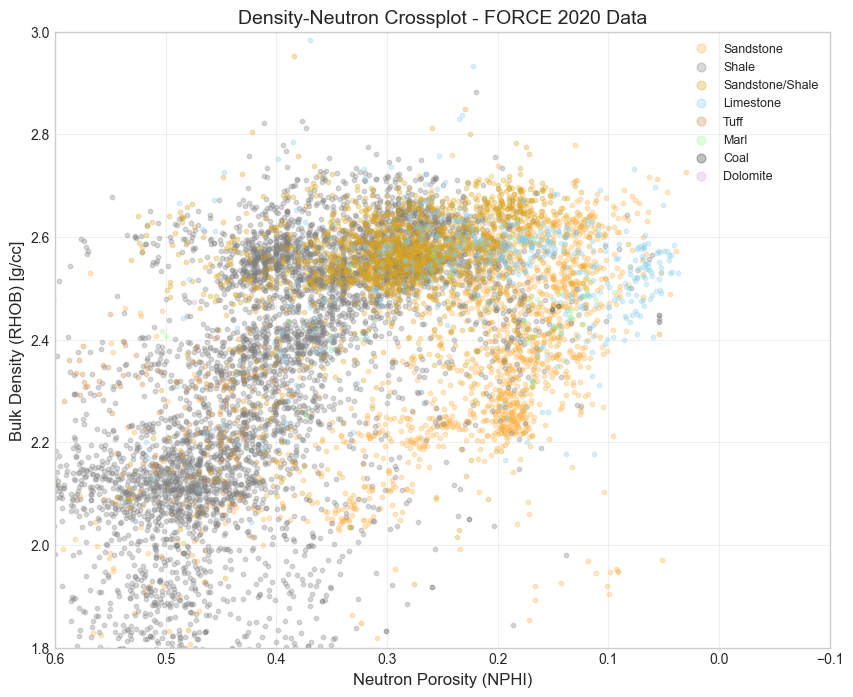

In [16]:
# Classic density-neutron crossplot
fig, ax = plt.subplots(figsize=(10, 8))

plot_df = df[['RHOB', 'NPHI', 'LITHOLOGY']].dropna()
if len(plot_df) > 10000:
    plot_df = plot_df.sample(n=10000, random_state=42)

colors_map = {
    'Sandstone': '#FFB347', 'Sandstone/Shale': '#DAA520', 'Shale': '#808080',
    'Limestone': '#87CEEB', 'Chalk': '#E0FFFF', 'Dolomite': '#DDA0DD',
    'Marl': '#98FB98', 'Coal': '#2F2F2F', 'Halite': '#FF69B4',
    'Anhydrite': '#BA55D3', 'Tuff': '#CD853F', 'Basement': '#8B0000'
}

for lithology in plot_df['LITHOLOGY'].unique():
    mask = plot_df['LITHOLOGY'] == lithology
    color = colors_map.get(lithology, '#999999')
    ax.scatter(plot_df.loc[mask, 'NPHI'], plot_df.loc[mask, 'RHOB'],
               alpha=0.3, label=lithology, c=color, s=10)

ax.set_xlabel('Neutron Porosity (NPHI)', fontsize=12)
ax.set_ylabel('Bulk Density (RHOB) [g/cc]', fontsize=12)
ax.set_title('Density-Neutron Crossplot - FORCE 2020 Data', fontsize=14)
ax.legend(loc='upper right', fontsize=9, markerscale=2)
ax.set_xlim(-0.1, 0.6)
ax.set_ylim(1.8, 3.0)
ax.invert_xaxis()
ax.grid(True, alpha=0.3)
plt.show()

### Discussion Questions

1. **What challenges do you observe in this real dataset?**

2. **How might missing data affect model training?**

3. **Looking at the crossplot, which lithologies overlap significantly?** How might this affect classification accuracy?

---

## Part 3: Preparing data for training

1. Use available well logs as features
2. Include GROUP and FORMATION (encoded as integers)
3. Include spatial coordinates (X_LOC, Y_LOC, Z_LOC, DEPTH_MD)
4. Handle missing values with imputation

In [17]:
# Define feature sets (following FORCE 2020 approach)

# Well log features
log_features = ['RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP',
                'BS', 'RMED', 'DRHO', 'CALI', 'RSHA', 'RMIC', 'SGR',
                'ROPA', 'RXO', 'DTS']

# Spatial features
spatial_features = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC']

# Categorical features (stratigraphic context - important!)
cat_features = ['GROUP', 'FORMATION']

# Filter to available columns
log_features = [f for f in log_features if f in df.columns]
spatial_features = [f for f in spatial_features if f in df.columns]
cat_features = [f for f in cat_features if f in df.columns]

print(f"Log features: {len(log_features)}")
print(f"Spatial features: {len(spatial_features)}")
print(f"Categorical features: {len(cat_features)}")

Log features: 17
Spatial features: 4
Categorical features: 2


In [18]:
# Prepare data
target_col = 'FORCE_2020_LITHOFACIES_LITHOLOGY'

# Remove rows with missing target
df_clean = df[df[target_col].notna()].copy()
print(f"Samples with valid target: {len(df_clean):,}")

Samples with valid target: 134,256


In [19]:
# Encode categorical features (GROUP, FORMATION)
cat_encoders = {}
for col in cat_features:
    df_clean[col] = df_clean[col].fillna('UNKNOWN')
    le = LabelEncoder()
    df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
    cat_encoders[col] = le
    print(f"{col}: {len(le.classes_)} categories")

encoded_cat_features = [f + '_encoded' for f in cat_features]

GROUP: 11 categories
FORMATION: 39 categories


In [20]:
# Combine all features
all_features = log_features + spatial_features + encoded_cat_features
print(f"\nTotal features: {len(all_features)}")
print(all_features)


Total features: 23
['RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'RMED', 'DRHO', 'CALI', 'RSHA', 'RMIC', 'SGR', 'ROPA', 'RXO', 'DTS', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP_encoded', 'FORMATION_encoded']


In [21]:
# Create feature matrix and target
X = df_clean[all_features].copy()
y = df_clean[target_col].values
wells = df_clean['WELL'].values

print(f"Feature matrix: {X.shape}")
print(f"Missing values: {X.isnull().sum().sum():,}")

Feature matrix: (134256, 23)
Missing values: 893,400


In [22]:
# Impute missing values with median
# This is acceptable from what we see in the EDA
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=all_features,
    index=X.index
)
print(f"After imputation: {X_imputed.isnull().sum().sum()} missing")

After imputation: 0 missing


In [23]:
# Encode target (lithology codes to 0-11)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Store the number of classes and their names for later use
n_classes = len(label_encoder.classes_)
all_class_labels = list(range(n_classes))
target_names = [lithology_keys.get(c, str(c)) for c in label_encoder.classes_]

print(f"Number of classes: {n_classes}")
print("Target encoding:")
for i, code in enumerate(label_encoder.classes_):
    name = lithology_keys.get(code, str(code))
    print(f"  {i}: {name}")

Number of classes: 9
Target encoding:
  0: Sandstone
  1: Shale
  2: Sandstone/Shale
  3: Limestone
  4: Dolomite
  5: Marl
  6: Anhydrite
  7: Coal
  8: Tuff


In [24]:
# Well-based train/test split (80/20)
# Important: split by wells to avoid data leakage!

unique_wells = np.unique(wells)
np.random.shuffle(unique_wells)

n_train = int(len(unique_wells) * 0.8)
train_wells = set(unique_wells[:n_train])
test_wells = set(unique_wells[n_train:])

train_idx = [i for i, w in enumerate(wells) if w in train_wells]
test_idx = [i for i, w in enumerate(wells) if w in test_wells]

X_train = X_imputed.iloc[train_idx].values
X_test = X_imputed.iloc[test_idx].values
y_train = y_encoded[train_idx]
y_test = y_encoded[test_idx]

print(f"Train: {len(train_wells)} wells, {len(X_train):,} samples")
print(f"Test: {len(test_wells)} wells, {len(X_test):,} samples")
print(f"\nClasses in train: {len(np.unique(y_train))}")
print(f"Classes in test: {len(np.unique(y_test))}")

Train: 7 wells, 105,633 samples
Test: 2 wells, 28,623 samples

Classes in train: 8
Classes in test: 9


---

## Part 4: Baseline Model

In [25]:
# Train baseline Random Forest
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)

print("Training baseline model...")
start_time = time.time()  # Start timer
rf_baseline.fit(X_train, y_train)

end_time = time.time()    # End timer
elapsed_time = end_time - start_time

# Evaluate
y_pred_base = rf_baseline.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base, average='weighted')

print(f"\nBaseline Results:")
print(f"  Training Time: {elapsed_time:.4f} seconds")
print(f"  Accuracy: {acc_base:.4f}")
print(f"  F1 (weighted): {f1_base:.4f}")

Training baseline model...

Baseline Results:
  Training Time: 1.7032 seconds
  Accuracy: 0.4871
  F1 (weighted): 0.4060


In [26]:
# Classification report
# Use labels parameter to handle cases where some classes may be missing from test set
print(classification_report(
    y_test, y_pred_base,
    labels=all_class_labels,
    target_names=target_names,
    zero_division=0
))

                 precision    recall  f1-score   support

      Sandstone       0.40      0.71      0.51      3592
          Shale       0.54      0.91      0.68     10596
Sandstone/Shale       0.77      0.09      0.16     13049
      Limestone       0.10      0.35      0.16       720
       Dolomite       0.00      0.00      0.00        15
           Marl       0.00      0.00      0.00        65
      Anhydrite       0.00      0.00      0.00         5
           Coal       0.00      0.00      0.00         7
           Tuff       0.72      0.49      0.58       574

       accuracy                           0.49     28623
      macro avg       0.28      0.28      0.23     28623
   weighted avg       0.62      0.49      0.41     28623



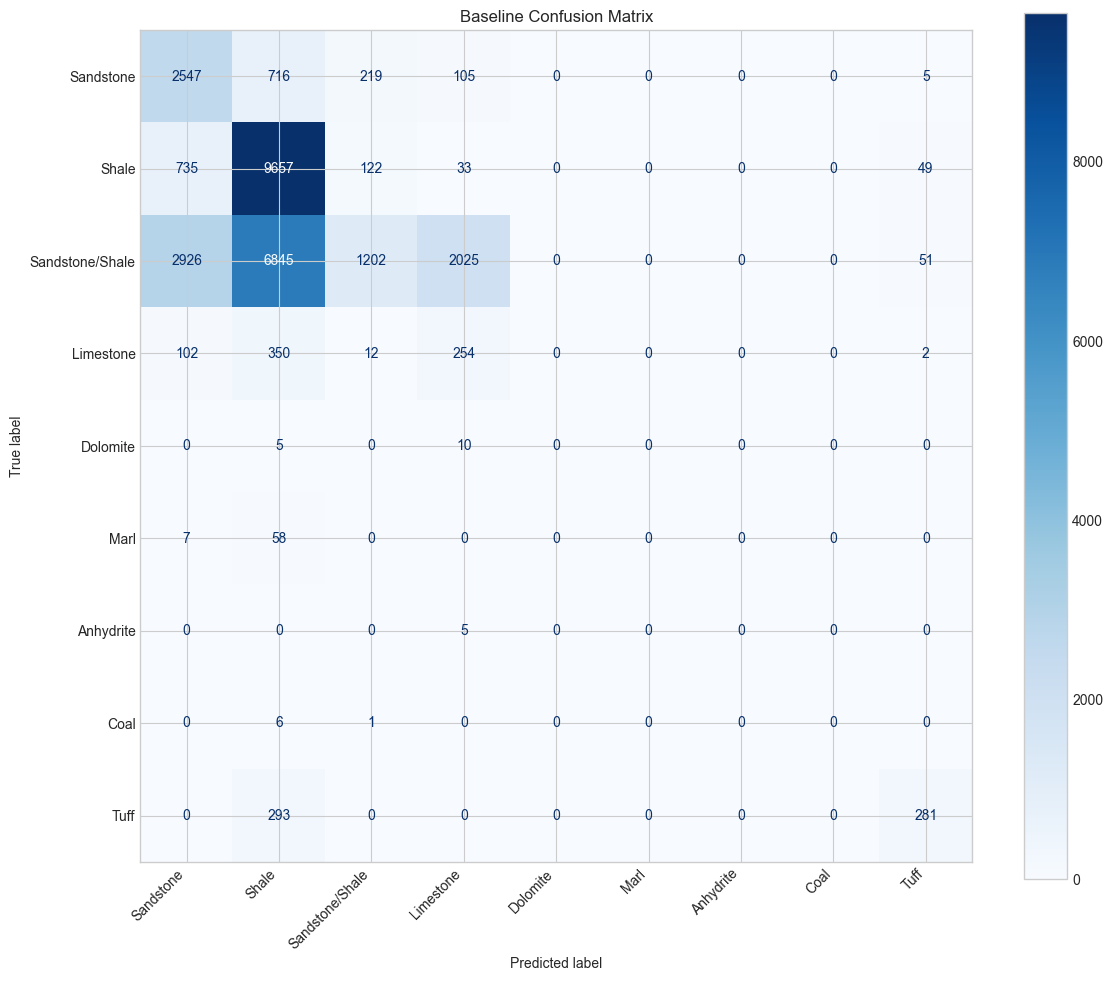

In [27]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_base, labels=all_class_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.xticks(rotation=45, ha='right')
plt.title('Baseline Confusion Matrix')
plt.tight_layout()
plt.show()

---

## Part 5: Hyperparameter Effects

n_estimators effect:
  n= 10: train=0.9975, test=0.4947
  n= 50: train=0.9999, test=0.4469
  n=100: train=1.0000, test=0.4871
  n=150: train=1.0000, test=0.4852


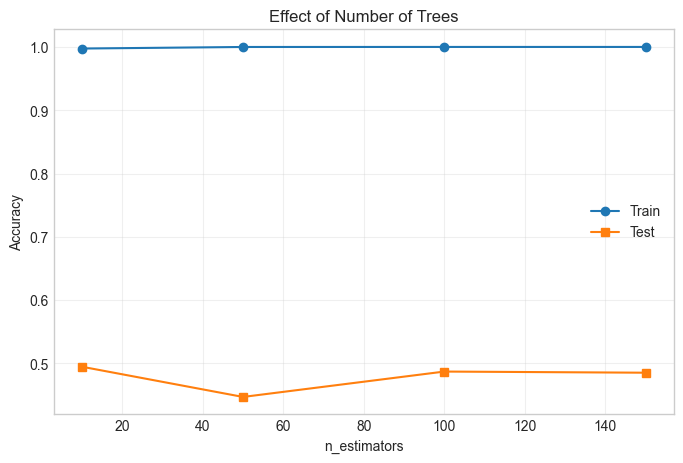

In [28]:
# Effect of n_estimators
n_values = [10, 50, 100, 150]
results = []

print("n_estimators effect:")
for n in n_values:
    rf = RandomForestClassifier(n_estimators=n, random_state=SEED, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_acc = rf.score(X_train, y_train)
    test_acc = rf.score(X_test, y_test)
    results.append({'n': n, 'train': train_acc, 'test': test_acc})
    print(f"  n={n:3d}: train={train_acc:.4f}, test={test_acc:.4f}")

# Plot
res_df = pd.DataFrame(results)
plt.figure(figsize=(8, 5))
plt.plot(res_df['n'], res_df['train'], 'o-', label='Train')
plt.plot(res_df['n'], res_df['test'], 's-', label='Test')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Effect of Number of Trees')
plt.grid(True, alpha=0.3)
plt.show()


max_depth effect:
  depth=5    : train=0.7955, test=0.3959
  depth=10   : train=0.9038, test=0.4524
  depth=15   : train=0.9627, test=0.4807
  depth=20   : train=0.9877, test=0.5050


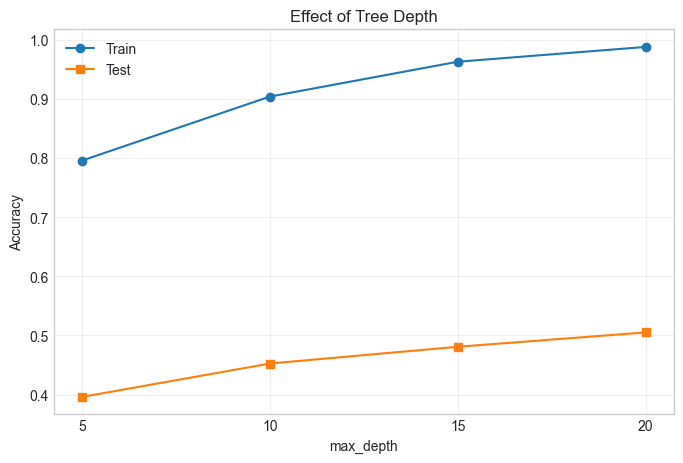

In [29]:
# Effect of max_depth
depths = [5, 10, 15, 20]
results = []

print("\nmax_depth effect:")
for d in depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=d, random_state=SEED, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_acc = rf.score(X_train, y_train)
    test_acc = rf.score(X_test, y_test)
    results.append({'depth': str(d), 'train': train_acc, 'test': test_acc})
    print(f"  depth={str(d):5s}: train={train_acc:.4f}, test={test_acc:.4f}")

# Plot
res_df = pd.DataFrame(results)
x = range(len(res_df))
plt.figure(figsize=(8, 5))
plt.plot(x, res_df['train'], 'o-', label='Train')
plt.plot(x, res_df['test'], 's-', label='Test')
plt.xticks(x, res_df['depth'])
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Effect of Tree Depth')
plt.grid(True, alpha=0.3)
plt.show()

In [30]:
# Effect of class_weight (for imbalanced data)
print("\nclass_weight effect:")
for w in [None, 'balanced', 'balanced_subsample']:
    rf = RandomForestClassifier(n_estimators=100, class_weight=w, random_state=SEED, n_jobs=-1)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1w = f1_score(y_test, pred, average='weighted')
    f1m = f1_score(y_test, pred, average='macro')
    print(f"  {str(w):20s}: acc={acc:.4f}, f1_weighted={f1w:.4f}, f1_macro={f1m:.4f}")


class_weight effect:
  None                : acc=0.4871, f1_weighted=0.4060, f1_macro=0.2335
  balanced            : acc=0.4299, f1_weighted=0.3155, f1_macro=0.1183
  balanced_subsample  : acc=0.4314, f1_weighted=0.3180, f1_macro=0.1277


## Part 6: Hyperparameter Tuning

Two generic approaches to parameter search are provided in scikit-learn: **GridSearchCV** and **RandomizedSearchCV**.

**GridSearchCV** exhaustively tests all combinations in a defined parameter grid, guaranteeing the best result within that grid, but is slow for large spaces; **RandomizedSearchCV** samples a fixed number of random combinations, making it much faster and efficient for vast or continuous spaces, though it might miss the absolute best parameter by chance. Use GridSearch for small, discrete spaces and RandomSearch for big data or complex models where time is a concern.


**When to Use Which**

**GridSearchCV:** When you have a small number of hyperparameters and discrete values, and computational time isn't a major issue.

**RandomizedSearchCV:** When dealing with large datasets or many hyperparameters where exploring everything is infeasible, or for continuous parameters.

In [34]:
# GridSearchCV for fine-tuning

# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [10, 15, 20, 30, 50, None],
#     'min_samples_split': [2, 5, 10, 15, 20],
#     'min_samples_leaf': [1, 2, 4, 8],
#     'max_features': ['sqrt', 'log2', 0.3, 0.5],
#     'class_weight': [None, 'balanced', 'balanced_subsample']
# }

param_grid = {
    'n_estimators': [100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 0.5],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=SEED, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("Running GridSearchCV...")
grid_search.fit(X_train, y_train)

print(f"\nBest F1 Score (CV): {grid_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")


Running GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best F1 Score (CV): 0.3131

Best Parameters:
  class_weight: balanced
  max_depth: 5
  max_features: sqrt
  min_samples_split: 5
  n_estimators: 100


---

## Part 7: Final Evaluation

In [35]:
# Final model evaluation
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

acc_tuned = accuracy_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

print("="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Baseline: acc={acc_base:.4f}, f1={f1_base:.4f}")
print(f"Tuned:    acc={acc_tuned:.4f}, f1={f1_tuned:.4f}")
print(f"\nImprovement: +{(acc_tuned-acc_base)*100:.2f}% accuracy")

FINAL RESULTS
Baseline: acc=0.4871, f1=0.4060
Tuned:    acc=0.4912, f1=0.4423

Improvement: +0.41% accuracy


In [36]:
# Final classification report
print("\nClassification Report (Tuned):")
print(classification_report(
    y_test, y_pred_tuned,
    labels=all_class_labels,
    target_names=target_names,
    zero_division=0
))


Classification Report (Tuned):
                 precision    recall  f1-score   support

      Sandstone       0.58      0.67      0.62      3592
          Shale       0.62      0.91      0.74     10596
Sandstone/Shale       0.90      0.09      0.16     13049
      Limestone       0.17      0.35      0.22       720
       Dolomite       0.00      0.73      0.00        15
           Marl       0.00      0.00      0.00        65
      Anhydrite       0.00      0.00      0.00         5
           Coal       0.09      1.00      0.16         7
           Tuff       0.35      1.00      0.52       574

       accuracy                           0.49     28623
      macro avg       0.30      0.53      0.27     28623
   weighted avg       0.73      0.49      0.44     28623



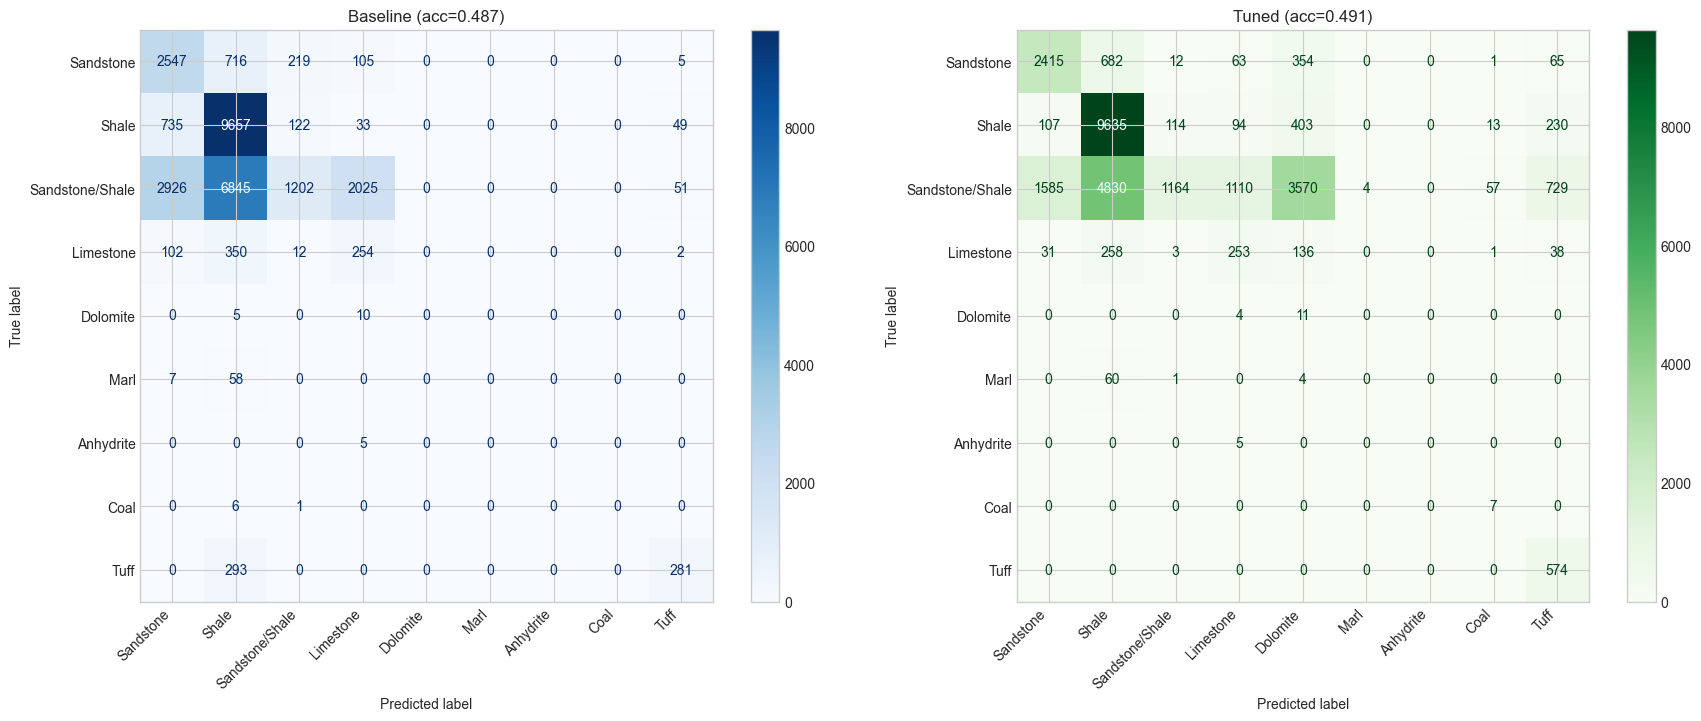

In [37]:
# Compare confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Baseline
cm1 = confusion_matrix(y_test, y_pred_base, labels=all_class_labels)
disp1 = ConfusionMatrixDisplay(cm1, display_labels=target_names)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Baseline (acc={acc_base:.3f})')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Tuned
cm2 = confusion_matrix(y_test, y_pred_tuned, labels=all_class_labels)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=target_names)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title(f'Tuned (acc={acc_tuned:.3f})')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

---

## Part 8: Model Interpretation

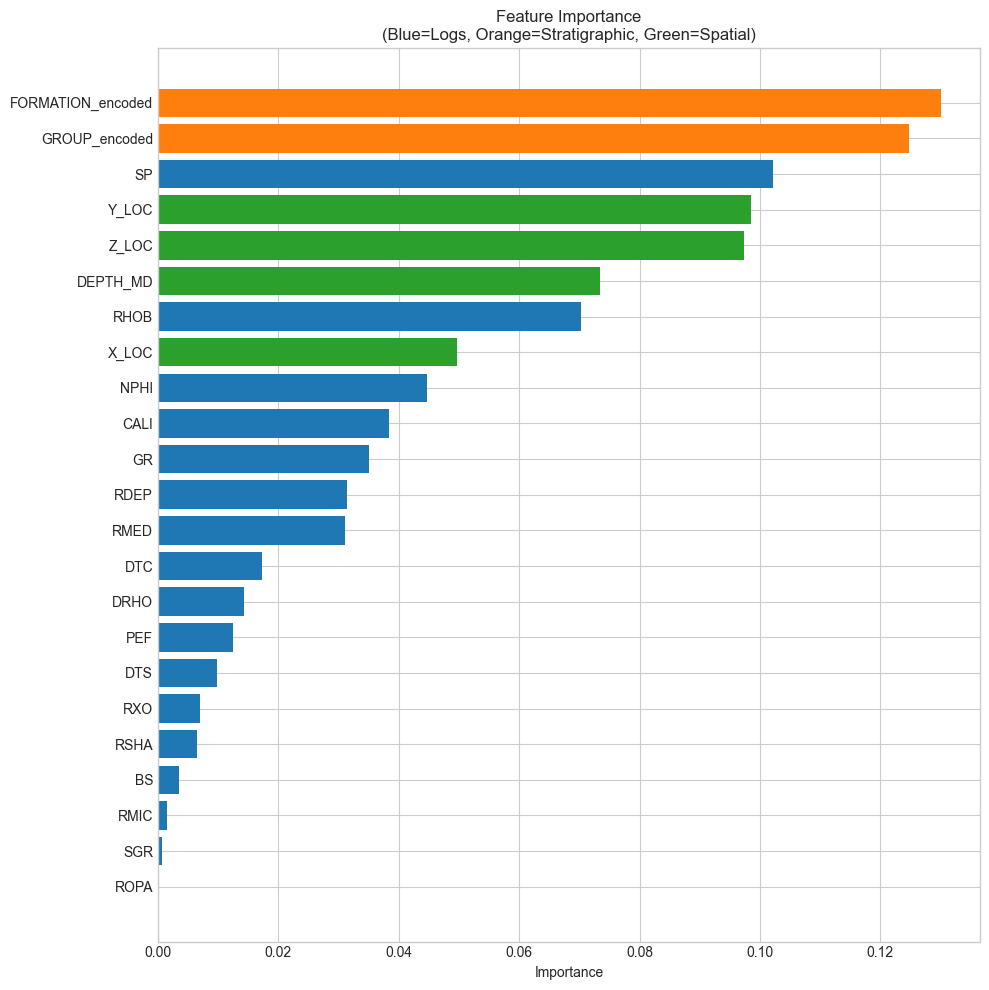


Top 5 features:
  FORMATION_encoded: 0.1300
  GROUP_encoded: 0.1247
  SP: 0.1022
  Y_LOC: 0.0986
  Z_LOC: 0.0973


In [38]:
# Feature importance
importance = pd.DataFrame({
    'feature': all_features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=True)

# Color by feature type
colors = []
for f in importance['feature']:
    if f in encoded_cat_features:
        colors.append('#ff7f0e')  # Orange for categorical
    elif f in spatial_features:
        colors.append('#2ca02c')  # Green for spatial
    else:
        colors.append('#1f77b4')  # Blue for logs

plt.figure(figsize=(10, 10))
plt.barh(importance['feature'], importance['importance'], color=colors)
plt.xlabel('Importance')
plt.title('Feature Importance\n(Blue=Logs, Orange=Stratigraphic, Green=Spatial)')
plt.tight_layout()
plt.show()

print("\nTop 5 features:")
for _, row in importance.tail(5).iloc[::-1].iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## Part 9: Permutation Importance

Unlike built-in importance (based on Gini impurity), permutation importance measures how much the model's performance decreases when a feature is randomly shuffled. This is more reliable for assessing true feature contribution.

We use permutation importance to check the importance of the features regardless of how the feature is shifted

Computing permutation importance (this may take a minute)...


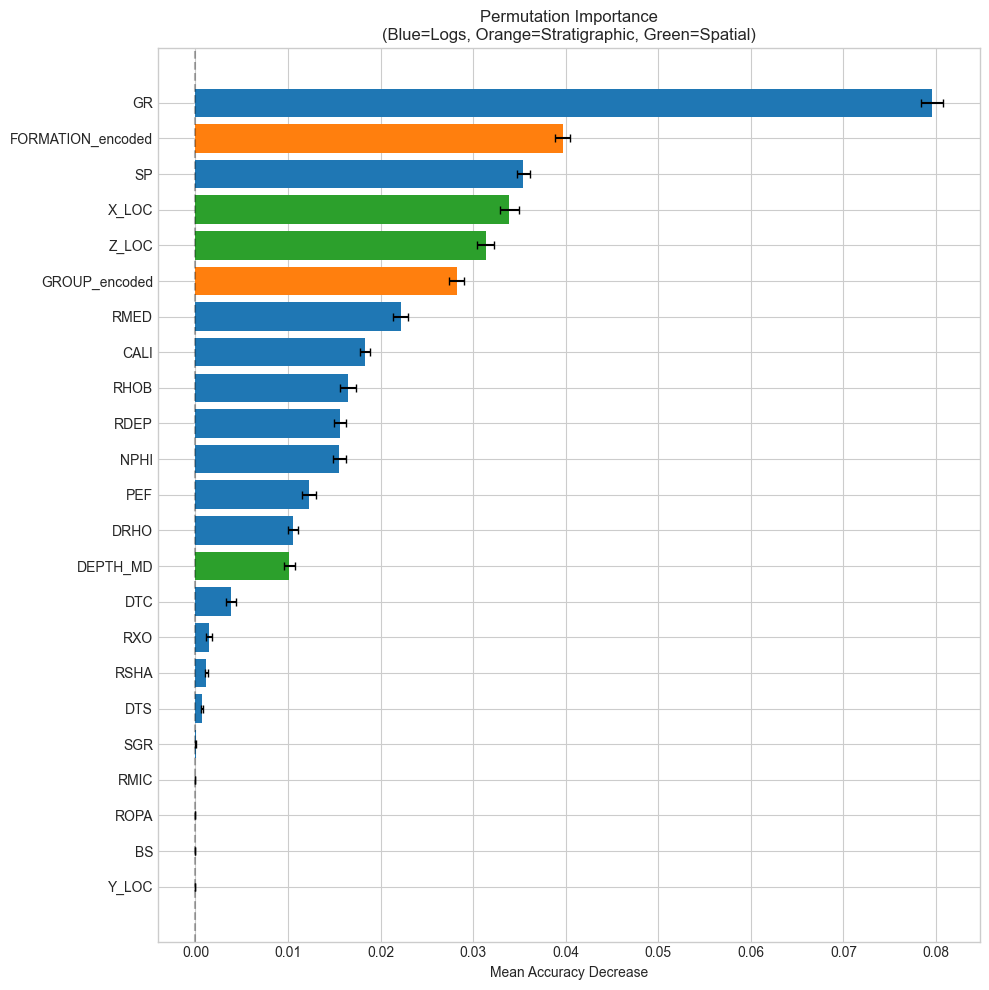


Top 5 features (permutation importance):
  GR: 0.0796 ± 0.0012
  FORMATION_encoded: 0.0397 ± 0.0008
  SP: 0.0354 ± 0.0007
  X_LOC: 0.0339 ± 0.0010
  Z_LOC: 0.0314 ± 0.0009


In [40]:
from sklearn.inspection import permutation_importance

print("Computing permutation importance (this may take a minute)...")
perm_result = permutation_importance(
    best_rf, X_test, y_test,
    n_repeats=10,
    random_state=SEED,
    n_jobs=-1,
    scoring='accuracy'
)

perm_importance = pd.DataFrame({
    'feature': all_features,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
}).sort_values('importance_mean', ascending=True)

# Color by feature type
perm_colors = []
for f in perm_importance['feature']:
    if f in encoded_cat_features:
        perm_colors.append('#ff7f0e')  # Orange for categorical
    elif f in spatial_features:
        perm_colors.append('#2ca02c')  # Green for spatial
    else:
        perm_colors.append('#1f77b4')  # Blue for logs

plt.figure(figsize=(10, 10))
plt.barh(perm_importance['feature'], perm_importance['importance_mean'],
         xerr=perm_importance['importance_std'], color=perm_colors, capsize=3)
plt.xlabel('Mean Accuracy Decrease')
plt.title('Permutation Importance\n(Blue=Logs, Orange=Stratigraphic, Green=Spatial)')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 features (permutation importance):")
for _, row in perm_importance.tail(5).iloc[::-1].iterrows():
    print(f"  {row['feature']}: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

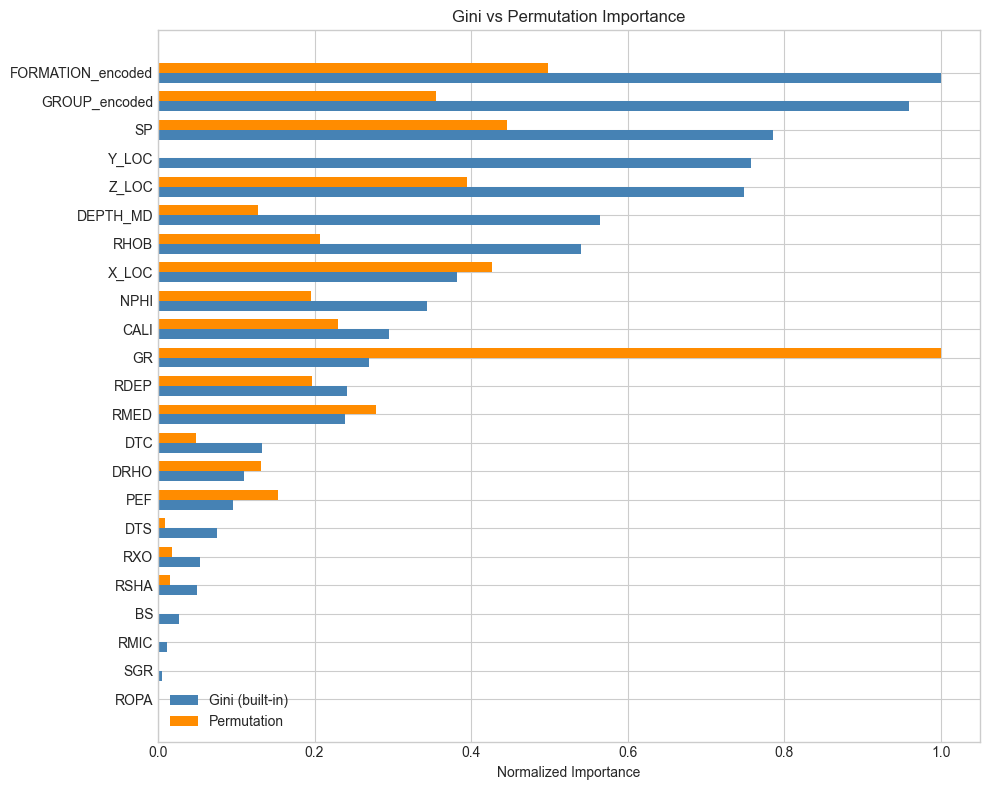


Note: Gini importance can overestimate high-cardinality features.
Permutation importance is often more reliable for interpretation.


In [41]:
# Compare Built-in vs Permutation Importance
comparison = importance.merge(
    perm_importance[['feature', 'importance_mean']],
    on='feature'
).rename(columns={
    'importance': 'Gini Importance',
    'importance_mean': 'Permutation Importance'
})

# Normalize for comparison
comparison['Gini (normalized)'] = comparison['Gini Importance'] / comparison['Gini Importance'].max()
comparison['Perm (normalized)'] = comparison['Permutation Importance'] / comparison['Permutation Importance'].max()

fig, ax = plt.subplots(figsize=(10, 8))
x = np.arange(len(comparison))
width = 0.35

bars1 = ax.barh(x - width/2, comparison['Gini (normalized)'], width, label='Gini (built-in)', color='steelblue')
bars2 = ax.barh(x + width/2, comparison['Perm (normalized)'], width, label='Permutation', color='darkorange')

ax.set_yticks(x)
ax.set_yticklabels(comparison['feature'])
ax.set_xlabel('Normalized Importance')
ax.set_title('Gini vs Permutation Importance')
ax.legend()
plt.tight_layout()
plt.show()

print("\nNote: Gini importance can overestimate high-cardinality features.")
print("Permutation importance is often more reliable for interpretation.")

Computing learning curve...


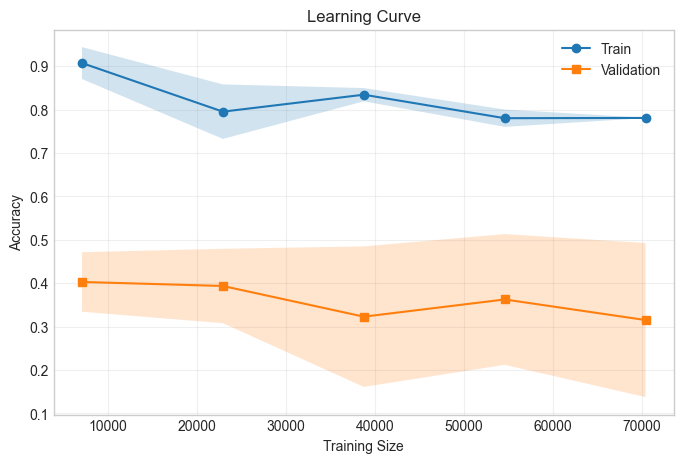

In [42]:
# Learning curve
print("Computing learning curve...")
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=3, n_jobs=-1
)

plt.figure(figsize=(8, 5))
plt.fill_between(train_sizes,
                 train_scores.mean(1) - train_scores.std(1),
                 train_scores.mean(1) + train_scores.std(1), alpha=0.2)
plt.fill_between(train_sizes,
                 val_scores.mean(1) - val_scores.std(1),
                 val_scores.mean(1) + val_scores.std(1), alpha=0.2)
plt.plot(train_sizes, train_scores.mean(1), 'o-', label='Train')
plt.plot(train_sizes, val_scores.mean(1), 's-', label='Validation')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## Summary

In [43]:
print("="*60)
print("SUMMARY")
print("="*60)
print(f"\nData: FORCE 2020 ({SAMPLE_FRAC*100:.0f}% sample)")
print(f"  Wells: {len(sampled_wells)} total ({len(train_wells)} train, {len(test_wells)} test)")
print(f"  Features: {len(all_features)}")
print(f"  Classes: {n_classes}")

print(f"\nPerformance:")
print(f"  Baseline: {acc_base:.4f} acc, {f1_base:.4f} F1")
print(f"  Tuned:    {acc_tuned:.4f} acc, {f1_tuned:.4f} F1")

print(f"\nBest parameters:")
for k, v in grid_search.best_params_.items():
    print(f"  {k}: {v}")

SUMMARY

Data: FORCE 2020 (10% sample)
  Wells: 9 total (7 train, 2 test)
  Features: 23
  Classes: 9

Performance:
  Baseline: 0.4871 acc, 0.4060 F1
  Tuned:    0.4912 acc, 0.4423 F1

Best parameters:
  class_weight: balanced
  max_depth: 5
  max_features: sqrt
  min_samples_split: 5
  n_estimators: 100


## Key Takeaways

1. **Stratigraphic features (GROUP, FORMATION) are highly predictive** - geological context matters!

2. **Well-based splitting prevents data leakage** from adjacent depth samples

3. **Class imbalance is severe** - use `class_weight='balanced'`

4. **Realistic accuracy is 60-75%** for 12-class lithology prediction

5. **Hyperparameter tuning provides modest improvement** (typically 3-8%)

## Reference

Bormann P., Aursand P., Dilib F., Dischington P., Manral S. 2020. FORCE Machine Learning Competition.  
https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition

______
---


## **Activity 2:** Using Automatic Feature Engineering (AFE) Tools (4 Parts, 15 Minutes)

Goal: Download a real earthquake waveform, slice it into windows (Noise vs. Event), and use tsfresh to discover which physical features (Kurtosis? Entropy? FFT?) best distinguish the earthquake from background noise.

In [44]:
!pip install obspy tsfresh


[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: pip install --upgrade pip


**Part 1:** Download Waveform and visualize it


Trace Shape: (4800,)


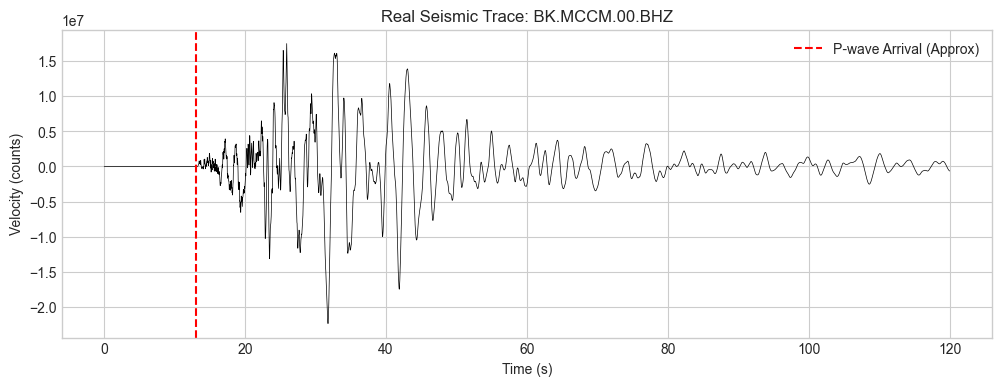

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

# 1. Setup Client (IRIS Data Management Center)
client = Client("IRIS")

# 2. Define Parameters for South Napa Earthquake (2014)
# Station: BK.MCCM (Marconi Conference Center)
t0 = UTCDateTime("2014-08-24T10:20:40")
duration = 120  # seconds

print("Downloading Seismic Data...")

try:
    # Attempt 1: Try specific station with wildcard location
    st = client.get_waveforms("BK", "MCCM", "*", "BHZ", t0, t0 + duration)
except Exception:
    print("Primary station failed, trying backup station (NC.KCT)...")
    # Attempt 2: Backup station (KCT - Konocti Clearlake) if MCCM is down
    st = client.get_waveforms("NC", "KCT", "*", "HHZ", t0, t0 + duration)

# Merge simply ensures we handle cases where the data is split into segments
st.merge(fill_value='interpolate')
trace = st[0]

# 3. Visualize the Real Physics
t_axis = np.linspace(0, duration, trace.stats.npts)
data = trace.data

print("Trace Shape:", trace.data.shape)
plt.figure(figsize=(12, 4))
plt.plot(t_axis, data, 'k', linewidth=0.5)
plt.axvline(x=13, color='r', linestyle='--', label='P-wave Arrival (Approx)')
plt.title(f"Real Seismic Trace: {trace.id}")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (counts)")
plt.legend()
plt.show()

**Part 2:** Slice and Label (Create the "Dataset")

tsfresh needs a collection of time series, not just one long one. We will slice this 120-second record into 2-second windows.

Noise Windows: Time 0 to 12s (Before the quake).

Event Windows: Time 13s to 40s (During the shaking).

In [ ]:
# Parameters
window_size = 100  # samples (assuming 40Hz -> 2.5 seconds per window)
step = 100         # non-overlapping
sampling_rate = trace.stats.sampling_rate

# Containers for tsfresh
df_list = []
y_labels = {} # 0 = Noise, 1 = Earthquake

# Loop through the data to create windows
current_sample = 0
window_id = 0
p_wave_sample_index = int(13 * sampling_rate) # P-wave arrives ~13s

while current_sample + window_size < len(data):
    # Slice the data
    window_data = data[current_sample : current_sample + window_size]
    time_steps = np.arange(window_size)

    # Label logic: If window is AFTER P-wave arrival, it's an Earthquake
    # We restrict "Earthquake" to the high energy part (13s to 50s)
    if current_sample > p_wave_sample_index and current_sample < (50 * sampling_rate):
        label = 1 # Earthquake
    elif current_sample < p_wave_sample_index:
        label = 0 # Noise
    else:
        # Skip the tail end for clear separation
        current_sample += step
        continue

    # Store labels
    y_labels[window_id] = label

    # Store data in "Long Format" for tsfresh (id, time, value)
    # We use a list of dictionaries for speed, then convert to DataFrame
    for t, val in zip(time_steps, window_data):
        df_list.append({'id': window_id, 'time': t, 'value': val})

    window_id += 1
    current_sample += step

# Convert to Pandas
df_seismic = pd.DataFrame(df_list)
y = pd.Series(y_labels)

print(f"Created {len(y)} windows (Samples). Class balance: {y.value_counts().to_dict()}")

Created 20 windows (Samples). Class balance: {1: 14, 0: 6}


**Part 3:** Extract and Select Features

Now we ask: "What makes an earthquake look different from noise?" Is it the max amplitude? The entropy? The Fourier coefficients? tsfresh will calculate ~700 features and tell us which ones matter.

In [ ]:
# 1. Extract Features
print("Extracting physical features with tsfresh...")
extracted_features = extract_features(df_seismic, column_id='id', column_sort='time')

# 2. Select Features (Benjamini-Hochberg filtering)
# This step removes irrelevant features to prevent overfitting.
impute(extracted_features) # Fix NaNs
features_filtered = select_features(extracted_features, y)

print(f"Total Features Extracted: {extracted_features.shape[1]}")
print(f"Significant Features Selected: {features_filtered.shape[1]}")
print("\nTop 5 Most Discriminative Features:")
print(features_filtered.columns[:5].tolist())

Extracting physical features with tsfresh...


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 11.18it/s]


Total Features Extracted: 783
Significant Features Selected: 142

Top 5 Most Discriminative Features:
['value__mean_abs_change', 'value__fft_coefficient__attr_"abs"__coeff_9', 'value__standard_deviation', 'value__fft_coefficient__attr_"abs"__coeff_40', 'value__fft_coefficient__attr_"abs"__coeff_2']


Discussion & Physical Interpretation
Look at the top features found by the algorithm.

value__abs_energy or value__standard_deviation: Likely picked because earthquakes carry more energy/variance than background noise.


value__kurtosis: "Kurtosis... detect[s] transient events, such as seismic P-wave arrivals". An earthquake signal has "heavy tails" compared to Gaussian background noise.


value__fft_coefficient: Seismic events have specific frequency contents (Spectral features).

### Unlike a "Black Box" Deep Learning model that creates opaque internal states, this workflow explicitly tells you: "I found an earthquake because the Kurtosis increased." This maps directly to the physical properties of the P-wave arrival.

Part 4: Visualizing the "Physical Fingerprint"
Slide Reference:

The code below takes the top features identified by tsfresh and creates:

Violin Plots: To show how the statistical distributions differ between noise (Class 0) and earthquakes (Class 1).

2D Feature Space: To show how these two features linearly separate the data, making it easy for a classifier to draw a line between them.

Plotting: value__mean_abs_change & value__fft_coefficient__attr_"abs"__coeff_9


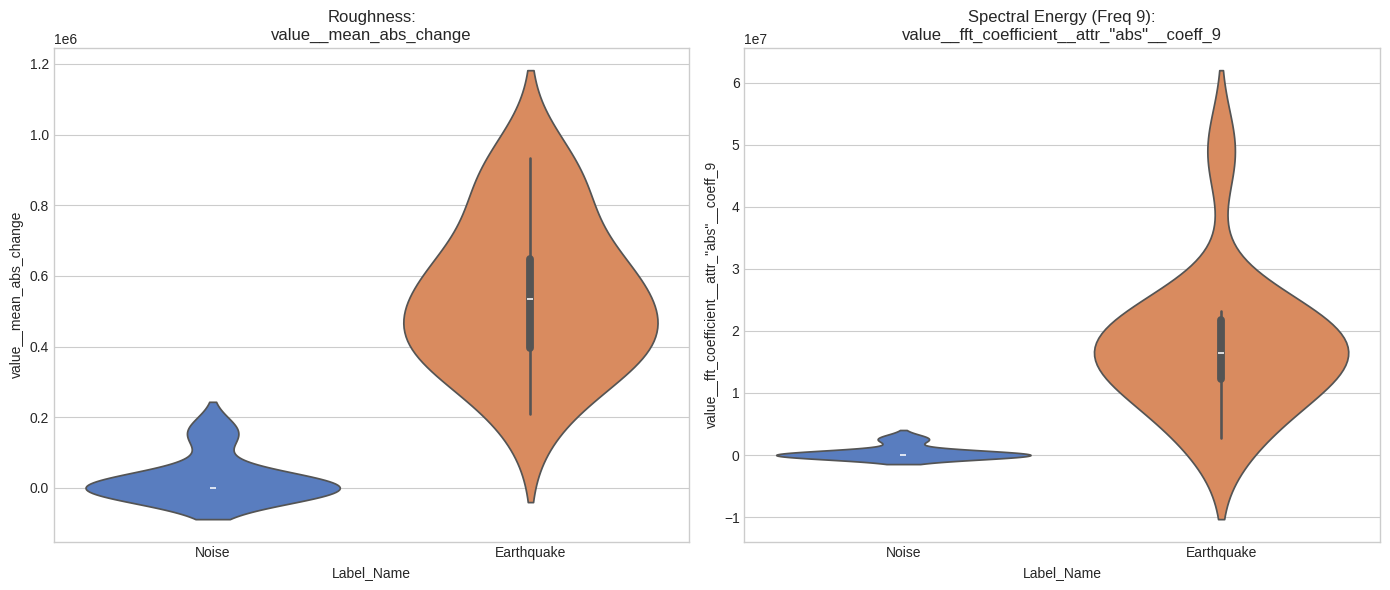

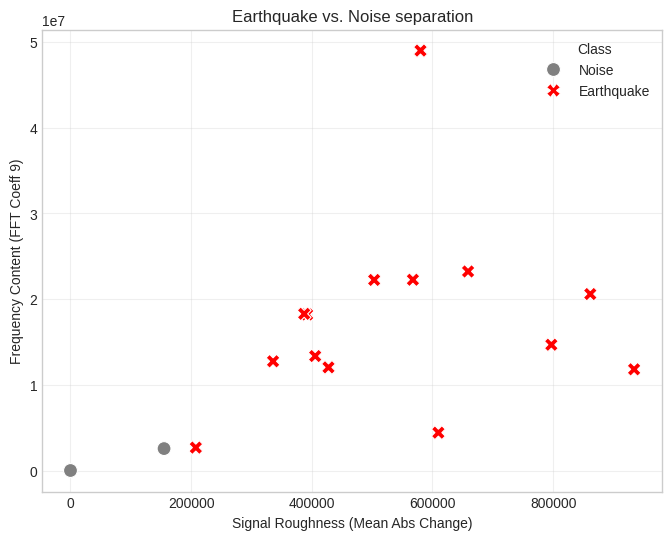

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = features_filtered.copy()
df_plot['Label'] = y.values
df_plot['Label_Name'] = df_plot['Label'].map({0: 'Noise', 1: 'Earthquake'})

feature_1 = 'value__mean_abs_change'
feature_2 = 'value__fft_coefficient__attr_"abs"__coeff_9'

# If the exact string above fails, we grab the first two columns dynamically:
if feature_2 not in df_plot.columns:
    feature_2 = features_filtered.columns[1]

print(f"Plotting: {feature_1} & {feature_2}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='Label_Name', y=feature_1, hue='Label_Name', data=df_plot, palette="muted", legend=False)
plt.title(f"Roughness:\n{feature_1}")

plt.subplot(1, 2, 2)
sns.violinplot(x='Label_Name', y=feature_2, hue='Label_Name', data=df_plot, palette="muted", legend=False)
plt.title(f"Spectral Energy (Freq 9):\n{feature_2}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=feature_1, y=feature_2, hue='Label_Name', style='Label_Name',
                data=df_plot, palette={'Noise': 'gray', 'Earthquake': 'red'}, s=100)

plt.title("Earthquake vs. Noise separation")
plt.xlabel("Signal Roughness (Mean Abs Change)")
plt.ylabel("Frequency Content (FFT Coeff 9)")
plt.legend(title='Class')
plt.grid(True, alpha=0.3)
plt.show()

Interpretation of the Visualizations

Violin Plots:

You see that for Abs Energy (or Standard Deviation), the "Earthquake" class has a much higher median and wider range than "Noise.

Scatter Plot:

You should see two distinct clusters. The gray dots (Noise) will likely be clustered in the corner (low energy, low complexity), while the red dots (Earthquake) will spread out towards higher values.

Takeaway: A simple Machine Learning model (like Logistic Regression) could draw a straight line through this plot to classify earthquakes with >95% accuracy, purely because tsfresh found the right physical features.

---

